<a href="https://colab.research.google.com/github/codiak/ds-topic-modeling-nike-shoe-reviews/blob/main/MSDSTopicModel_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling for Nike Sneaker Research

## Data Fetching

Before continuing with this lab, be sure you have completed Homework 2 and saved your corpus and topic model to your Google Drive. They should be files in the root of your Google Drive called MSDS_HW2_corpus.p and MSDS_HW2_model.p. In this lab, you will load the model and use it for classification of documents in the corpus.

In [1]:
import gzip
import json

Access data files in Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = "drive/MyDrive/MSDS_marketing_text_analytics"

Mounted at /content/drive


In [16]:
asins = []
sales_ranks = {}

with gzip.open(f"{folder_path}/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    i = 0
    for product in products:
        i += 1
        # print(product)
        # if i > 10000:
        #   break
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
        sneaker_cats = ["fashion sneakers", "sneakers", "shoes"]
        if "nike" in categories:
            if any(x in categories for x in sneaker_cats):
                asins.append(data["asin"])
                if data.get("salesRank"):
                    sales_ranks[data["asin"]] = list(data["salesRank"].items())[0][1]

In [18]:
print(len(asins))
asins[:3]

6611


['B0002164KC', 'B0006NGUE6', 'B0007IA7O4']

In [19]:
print(len(sales_ranks))
dict(list(sales_ranks.items())[:3])

6356


{'B0002164KC': 1067625, 'B0006NGUE6': 45137, 'B0007IA7O4': 24189}

### Exploring Sales Rank

Looking at top items and distribution.

In [20]:
import operator
ordered_asin_ranks = sorted(sales_ranks.items(), key=operator.itemgetter(1))
ordered_asin_ranks[0]

('B00EQBFL62', 179)

<ipython-input-21-a00462e37432>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(list(sales_ranks.values()))


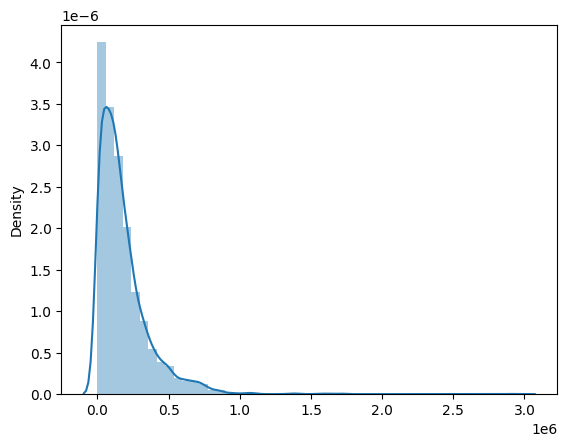

In [21]:
import seaborn as sns
plot = sns.distplot(list(sales_ranks.values()))

## Data Cleaning

Trim the long tail of products, allowing a lower rank since this is focused on a subcategory (sneaker).

In [24]:
best_asins = [asin for asin, rank in sales_ranks.items() if rank <= 15000]
len(best_asins)

598

## Pulling in Review Text

Time to aggregate reviews for the selected ASINs.

In [25]:
top_reviews = {}

with gzip.open(f"{folder_path}/reviews_Clothing_Shoes_and_Jewelry.json.gz") as reviews:
    for i, review in enumerate(reviews):
        review = json.loads(review)
        _id = "%s.%s" % (review["asin"], review["reviewerID"])
        if review["asin"] in best_asins:
            top_reviews[_id] = review

In [26]:
# How many do we have?
len(top_reviews)

5353

In [27]:
# Save for reference/checkpoint
with open(f"{folder_path}/NikeSneaker_TopReviews.jsonl", "w") as top_reviews_file:
    for k, v in top_reviews.items():
        review = json.dumps(v)
        top_reviews_file.write(f"{review}\n")

In [73]:
# remove conflicting dependencies for preprocessing
!pip uninstall -y numba
!pip uninstall -y tensorflow

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# fetch required dependencies
!pip install lda
!pip install "tmtoolkit[recommended]"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached numpy-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires numba>=0.57, which is not installed.
dopamine-rl 4.0.9 requires tensorflow>=2.2.0, which is not installed.
librosa 0.10.2.post1 requires numba>=0.51.0, which is not installed.
rmm-cu12 24.4.0 requires numba>=0.57, which is not installed.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.0 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.0 which is incompatible.
ibis-framework 8.0.0 requires numpy<2

In [75]:
# preprocessing dependency imports
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import vocabulary
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from string import punctuation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
def build_corpus(texts, lang="en"):

    corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)
    lemmatize(corpus)
    to_lowercase(corpus)
    remove_chars(corpus, punctuation)
    filter_clean_tokens(corpus, remove_shorter_than=3, remove_numbers=True)
    return corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
# REDUCED_REVIEWS_FILE = "drive/MyDrive/MSDS_marketing_text_analytics/reviews_Clothing_Shoes_and_Jewelry_5.json.gz"
FULL_REVIEWS_FILE = "drive/MyDrive/MSDS_marketing_text_analytics/reviews_Clothing_Shoes_and_Jewelry.json.gz"

reviews = []
with gzip.open(FULL_REVIEWS_FILE) as f:
    for review in f:
        data = json.loads(review)
        if data["asin"] in best_asins:
            text = data["reviewText"]
            if text and len(text) > 3:
                reviews.append(text)
        if len(reviews) >= 1000:
            break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Inspect a Few Reviews

In [78]:
len(reviews)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1000

In [80]:
for i, review in enumerate(reviews[:5]):
    print(i, review[:80])

0 Just as expected. This pair is perfect for work and are very comfortable. Great 
1 Too tight which makr it uncomfortable, I think the size may not be accurate. Est
2 They seem like super-cheap Chinese shoes. Not usual Nike quality. First of all, 
3 They are very comfortable and I've gotten lots of compliments from people. If yo
4 Normally my friend wears a size 11, so I bought these the same size even though 


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Save review text as json for reference/checkpoint
with open(f"{folder_path}/NikeSneaker_TopReviews_Text.jsonl", "w") as top_reviews_text:
    for i, review in enumerate(reviews):
        top_reviews_text.write(f"{i}\t{review}\n")


# Model Building

Now that the data is prepared, time to preprocess the reviews and train a model.

### Build Document Corpus

In [81]:
reviews_corpus = build_corpus(reviews)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
dtms = {
    "reviews_corpus": dtm(reviews_corpus)
}
lda_params = {
    'n_topics': 10,
    'eta': .01,
    'n_iter': 10,
    'random_state': 1234,
    'alpha': 1/16
}

models = compute_models_parallel(dtms, constant_parameters=lda_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### View the Topics

In [83]:
model = models["reviews_corpus"][0][1]
print_ldamodel_topic_words(model.topic_word_, vocabulary(reviews_corpus), top_n=5)

topic_1
> #1. shoe (0.043356)
> #2. wear (0.033855)
> #3. fit (0.028510)
> #4. foot (0.023760)
> #5. size (0.021384)
topic_2
> #1. size (0.030632)
> #2. shoe (0.030007)
> #3. great (0.028757)
> #4. comfortable (0.028132)
> #5. order (0.027507)
topic_3
> #1. foot (0.035226)
> #2. nike (0.025988)
> #3. size (0.024256)
> #4. pair (0.022524)
> #5. flop (0.022524)
topic_4
> #1. sandal (0.038317)
> #2. nike (0.034354)
> #3. wear (0.030391)
> #4. size (0.027749)
> #5. buy (0.023785)
topic_5
> #1. shoe (0.067866)
> #2. great (0.049454)
> #3. buy (0.040511)
> #4. comfortable (0.034199)
> #5. love (0.031568)
topic_6
> #1. shoe (0.056975)
> #2. foot (0.048052)
> #3. size (0.039130)
> #4. good (0.038443)
> #5. fit (0.037757)
topic_7
> #1. shoe (0.042908)
> #2. fit (0.033844)
> #3. wear (0.027197)
> #4. buy (0.027197)
> #5. comfortable (0.025384)
topic_8
> #1. shoe (0.072690)
> #2. buy (0.030082)
> #3. look (0.028203)
> #4. wear (0.027576)
> #5. great (0.027576)
topic_9
> #1. shoe (0.066271)
> #2. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
# Save model for reference
import pickle
from tmtoolkit.topicmod.model_io import save_ldamodel_to_pickle

with open(f"{folder_path}/NikeShoeReviews_model.p", "wb") as modelfile:
    save_ldamodel_to_pickle(modelfile, model, vocabulary(reviews_corpus), reviews_corpus.doc_labels, dtm=dtm(reviews_corpus))

with open(f"{folder_path}/NikeShoeReviews.p", "wb") as reviewsfile:
    pickle.dump(reviews, reviewsfile)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Classification and Topic Analysis

In [85]:
# Install requirements
import numpy as np
import pickle

try:
  import pyLDAvis
except:
  !pip install pyLDAvis==3.4.1
  import pyLDAvis

try:
  import tmtoolkit
except:
  !pip install tmtoolkit
  import tmtoolkit

try:
  from lda import LDA
except:
  !pip install lda
  from lda import LDA

from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics
from tmtoolkit.topicmod.model_io import load_ldamodel_from_pickle
from tmtoolkit.topicmod.visualize import parameters_for_ldavis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
# prompt: Ensure matplotlib version 3.1.3 is installed. Restart the kernel if a different version is installed after installing.
# !pip install matplotlib==3.1.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Classification

Generate topic labels.

In [90]:
from tmtoolkit.corpus import dtm
vocab = vocabulary(reviews_corpus)
dtm = dtm(reviews_corpus)
doc_labels = reviews_corpus.doc_labels

topic_labels = generate_topic_labels_from_top_words(
    model.topic_word_,
    model.doc_topic_,
    doc_lengths(dtm),
    np.array(vocab),
    n_words=5
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
topic_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['1_shoe_wear_fit_foot_size', '2_size_shoe_great_comfortable_order',
       '3_foot_nike_size_pair_flop', '4_sandal_nike_wear_size_buy',
       '5_shoe_great_buy_comfortable_love', '6_shoe_foot_size_good_fit',
       '7_shoe_fit_wear_buy_comfortable', '8_shoe_buy_look_wear_great',
       '9_shoe_great_fit_comfortable_nice',
       '10_foot_sandal_size_like_shoe'], dtype='<U35')

Document classifications can be retrieved via [ldamodel_top_doc_topics](https://tmtoolkit.readthedocs.io/en/latest/api.html?highlight=ldamodel_top_doc_topics#tmtoolkit.topicmod.model_io.ldamodel_top_doc_topics)

In [92]:
doc_topic = model.doc_topic_
documentclassifications = ldamodel_top_doc_topics(doc_topic, doc_labels, top_n=2, topic_labels=topic_labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
documentclassifications.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank_1,rank_2
document,,
0,4_sandal_nike_wear_size_buy (0.6647),3_foot_nike_size_pair_flop (0.1941)
1,10_foot_sandal_size_like_shoe (0.6935),9_shoe_great_fit_comfortable_nice (0.1774)
2,3_foot_nike_size_pair_flop (0.4317),10_foot_sandal_size_like_shoe (0.1976)
3,5_shoe_great_buy_comfortable_love (0.5594),8_shoe_buy_look_wear_great (0.401)
4,5_shoe_great_buy_comfortable_love (0.4394),6_shoe_foot_size_good_fit (0.3909)


### Spot Checking Review Classification



Add the corpus text to compare topic results.

In [97]:
documentclassifications["text"] = reviews
documentclassifications.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank_1,rank_2,text
document,,,
464,10_foot_sandal_size_like_shoe (0.6386),7_shoe_fit_wear_buy_comfortable (0.1634),These are very comfy and I like them a lot. Th...
935,1_shoe_wear_fit_foot_size (0.58),10_foot_sandal_size_like_shoe (0.388),Love these slides! I've had 2 different pair o...
815,1_shoe_wear_fit_foot_size (0.3551),7_shoe_fit_wear_buy_comfortable (0.2391),"i have had this type thong before , just neede..."
701,7_shoe_fit_wear_buy_comfortable (0.6132),10_foot_sandal_size_like_shoe (0.1604),I bought this for my stepson. He seems to be h...
145,2_size_shoe_great_comfortable_order (0.4329),7_shoe_fit_wear_buy_comfortable (0.2181),Got em for my hubbys birthday. He loves the da...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualization

Looking at the distribution of topics and salient terms.

In [95]:
ldavis_params = parameters_for_ldavis(
    model.topic_word_,
    model.doc_topic_,
    dtm,
    vocab
)
print(ldavis_params.keys())

dict_keys(['topic_term_dists', 'doc_topic_dists', 'vocab', 'doc_lengths', 'term_frequency', 'sort_topics'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
%matplotlib inline
# pyLDAvis.drop('saliency', axis=1)
vis = pyLDAvis.prepare(**ldavis_params)
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Potential Insights



Once you have completed execution of the above code, and have generated the visualization of your topic model, submit a screenshot of your interactive LDAvis above as proof of completion of the lab. This should be submitted as an image file in the peer review assessment after Lab 2 in Coursera.